# Weather Data Preprocessing


### Understand weather data structure

Understand the schema, granularity, and contents of the weather JSON files. 


We have weather data for 10 airports: `ATL, EWR, JFK, LAS, LAX, MCO, MIA, ORD, SEA, SFO`

For each airport has 3 JSON files:
- `2016_1.json`
- `2016_2.json`
- `2016_3.json`

Each JSON file contains:
- Daily weather records
- Each day contains 24 hourly observations

### Load Representative Weather Data
Loading weather data for one airport and one month from the file `ATL/2016_1.json`.

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import os
import json



# Define the list of target airports for filtering
airports = ["ATL", "EWR", "JFK", "LAS", "LAX", "MCO", "MIA", "ORD", "SEA", "SFO"]

In [2]:
weather_file = "Data/Weather_Data/ATL/2016_1.json"

with open(weather_file, "r") as f:
    raw = json.load(f)

# Extract daily weather list
daily_weather = raw["data"]["weather"]

# Convert to DataFrame
daily_df = pd.DataFrame(daily_weather)

print(daily_df.shape,daily_df.dtypes)

daily_df.head()


(31, 10) mintempC        object
maxtempF        object
sunHour         object
mintempF        object
maxtempC        object
hourly          object
totalSnow_cm    object
date            object
astronomy       object
uvIndex         object
dtype: object


,mintempC,maxtempF,sunHour,mintempF,maxtempC,hourly,totalSnow_cm,date,astronomy,uvIndex
0,5,51,7.5,42,11,"[{'windspeedKmph': '11', 'FeelsLikeF': '46', '...",0.0,2016-01-01,"[{'moon_phase': 'Waning Gibbous', 'moonrise': ...",0
1,2,48,9.0,35,9,"[{'windspeedKmph': '15', 'FeelsLikeF': '34', '...",0.0,2016-01-02,"[{'moon_phase': 'Last Quarter', 'moonrise': '0...",0
2,3,51,7.5,38,11,"[{'windspeedKmph': '10', 'FeelsLikeF': '37', '...",0.0,2016-01-03,"[{'moon_phase': 'Last Quarter', 'moonrise': '0...",0
3,-1,46,9.5,31,8,"[{'windspeedKmph': '13', 'FeelsLikeF': '37', '...",0.0,2016-01-04,"[{'moon_phase': 'Last Quarter', 'moonrise': '0...",0
4,1,43,10.0,33,6,"[{'windspeedKmph': '12', 'FeelsLikeF': '28', '...",0.0,2016-01-05,"[{'moon_phase': 'Waning Crescent', 'moonrise':...",0


In [3]:
hourly_sample = pd.DataFrame(daily_weather[0]["hourly"])
hourly_sample.head()



,windspeedKmph,FeelsLikeF,winddir16Point,FeelsLikeC,DewPointC,windspeedMiles,DewPointF,HeatIndexF,cloudcover,HeatIndexC,...,weatherDesc,visibility,weatherCode,tempC,tempF,WindChillF,WindChillC,winddirDegree,humidity,time
0,11,46,NW,8,8,7,47,49,100,10,...,[{'value': 'Patchy rain possible'}],10,176,10,49,46,8,318,91,0
1,13,42,NW,6,7,8,44,46,100,8,...,[{'value': 'Patchy rain possible'}],10,176,8,46,42,6,317,92,100
2,14,38,NW,3,5,9,41,43,100,6,...,[{'value': 'Overcast'}],10,122,6,43,38,3,315,92,200
3,16,33,NW,1,3,10,38,40,100,4,...,[{'value': 'Overcast'}],10,122,4,40,33,1,314,93,300
4,17,33,NW,1,3,10,38,40,100,4,...,[{'value': 'Overcast'}],10,122,4,40,33,1,314,93,400


A representative weather JSON file was explored and converted into a daily-level DataFrame to inspect its structure, shape, and available attributes. The data consists of one row per day with nested hourly weather records, confirming the need for flattening before further processing.

#### Flatten hourly weather into a DataFrame (ATL, Jan 2016)

Now, convert the nested daily to hourly structure into a tabular dataset with: 1 row per (airport, date, hour)

So that we can later combine across airports and months and keep weather variables that directly affect delays and are common across all files:

`tempC, FeelsLikeC, windspeedKmph, windgustKmph, winddirDegree, humidity, pressure, visibility, precipMM, cloudcover, weatherCode`

- We can add/remove these later.

In [4]:
airport = "ATL"
rows = []

# Iterate through each day's weather data in the daily_weather list
for day in daily_weather:
    # Convert the date string to a datetime object and extract the date component
    day_date = pd.to_datetime(day["date"], errors="coerce")

    # Iterate through each hourly observation within the day
    for hr in day["hourly"]:
        # Convert hour field (e.g., "0", "300", "1200") to an integer hour (0-23)
        # Pad with zeros to ensure 4 digits, then extract the first two digits as the hour
        t = str(hr.get("time", "0")).zfill(4)   # "0" -> "0000"
        hour = int(t[:2])                       # "0000" -> 0, "2300" -> 23

        # Map hourly weather attributes to a dictionary, converting values to numeric types
        rows.append({
            "airport": airport,
            "date": day_date,
            "hour": hour,
            "tempC": pd.to_numeric(hr.get("tempC"), errors="coerce"),
            "FeelsLikeC": pd.to_numeric(hr.get("FeelsLikeC"), errors="coerce"),
            "windspeedKmph": pd.to_numeric(hr.get("windspeedKmph"), errors="coerce"),
            "windgustKmph": pd.to_numeric(hr.get("WindGustKmph") or hr.get("windgustKmph"), errors="coerce"),
            "winddirDegree": pd.to_numeric(hr.get("winddirDegree"), errors="coerce"),
            "humidity": pd.to_numeric(hr.get("humidity"), errors="coerce"),
            "pressure": pd.to_numeric(hr.get("pressure"), errors="coerce"),
            "visibility": pd.to_numeric(hr.get("visibility"), errors="coerce"),
            "precipMM": pd.to_numeric(hr.get("precipMM"), errors="coerce"),
            "cloudcover": pd.to_numeric(hr.get("cloudcover"), errors="coerce"),
            "weatherCode": pd.to_numeric(hr.get("weatherCode"), errors="coerce"),
        })

# Construct a pandas DataFrame from the accumulated list of hourly records
atl_hourly_df = pd.DataFrame(rows)

# Output the dimensions and the first few rows of the processed DataFrame
atl_hourly_df.shape, atl_hourly_df.head()


((744, 14),
   airport       date  hour  tempC  FeelsLikeC  windspeedKmph  windgustKmph  \
 0     ATL 2016-01-01     0     10           8             11            17   
 1     ATL 2016-01-01     1      8           6             13            22   
 2     ATL 2016-01-01     2      6           3             14            26   
 3     ATL 2016-01-01     3      4           1             16            30   
 4     ATL 2016-01-01     4      4           1             17            30   
 
    winddirDegree  humidity  pressure  visibility  precipMM  cloudcover  \
 0            318        91      1023          10       0.1         100   
 1            317        92      1023          10       0.0         100   
 2            315        92      1023          10       0.0         100   
 3            314        93      1023          10       0.0         100   
 4            314        93      1023          10       0.0         100   
 
    weatherCode  
 0          176  
 1          176  
 2    

#### Validation checks

In [5]:
# Expected ~ 31 days * 24 hours = 744 rows
print("Rows:", len(atl_hourly_df))
print("Unique dates:", atl_hourly_df["date"].nunique())
print("Hour range:", atl_hourly_df["hour"].min(), atl_hourly_df["hour"].max())

# Check duplicates (should be 0)
dups = atl_hourly_df.duplicated(subset=["airport", "date", "hour"]).sum()
print("Duplicate airport-date-hour rows:", dups)


Rows: 744
Unique dates: 31
Hour range: 0 23
Duplicate airport-date-hour rows: 0


In [6]:
# Calculate the proportion of missing values for each column, 
atl_hourly_df.isna().mean().sort_values(ascending=False).head(10)


airport          0.0
date             0.0
hour             0.0
tempC            0.0
FeelsLikeC       0.0
windspeedKmph    0.0
windgustKmph     0.0
winddirDegree    0.0
humidity         0.0
pressure         0.0
dtype: float64

Validation confirms a dataset of 744 rows and 14 columns, perfectly matching the expected 31-day, 24-hour granularity. The data is complete with no missing values or duplicates, providing a clean primary key (airport-date-hour) for merging. This schema includes all necessary weather features for flight-delay modeling, requiring no further imputation.

#### Flatten all weather files & combine into one dataset

In [7]:
def flatten_weather_json(weather_file, airport):
    
    # Load raw JSON data from file
    with open(weather_file, "r") as f:
        raw = json.load(f)

    # Extract the list of daily weather records
    daily_weather = raw["data"]["weather"]
    rows = []

    # Iterate through each day in the dataset
    for day in daily_weather:
        # Convert date string to datetime object
        day_date = pd.to_datetime(day["date"], errors="coerce")

        # Iterate through hourly measurements for the day
        for hr in day["hourly"]:
            # Standardize time format (e.g., '0' -> '0000') and extract the hour component
            t = str(hr.get("time", "0")).zfill(4)
            hour = int(t[:2])

            # Build a dictionary for the current hour, converting values to numeric types
            rows.append({
                "airport": airport,
                "date": day_date,
                "hour": hour,
                "tempC": pd.to_numeric(hr.get("tempC"), errors="coerce"),
                "FeelsLikeC": pd.to_numeric(hr.get("FeelsLikeC"), errors="coerce"),
                "windspeedKmph": pd.to_numeric(hr.get("windspeedKmph"), errors="coerce"),
                "windgustKmph": pd.to_numeric(
                    hr.get("WindGustKmph") or hr.get("windgustKmph"),
                    errors="coerce"
                ),
                "winddirDegree": pd.to_numeric(hr.get("winddirDegree"), errors="coerce"),
                "humidity": pd.to_numeric(hr.get("humidity"), errors="coerce"),
                "pressure": pd.to_numeric(hr.get("pressure"), errors="coerce"),
                "visibility": pd.to_numeric(hr.get("visibility"), errors="coerce"),
                "precipMM": pd.to_numeric(hr.get("precipMM"), errors="coerce"),
                "cloudcover": pd.to_numeric(hr.get("cloudcover"), errors="coerce"),
                "weatherCode": pd.to_numeric(hr.get("weatherCode"), errors="coerce"),
            })

    # Convert the list of dictionaries into a DataFrame
    return pd.DataFrame(rows)

#### Loop through all airports & months

Directory structure:

```
Data/Weather_Data/
├── ATL/
├── EWR/
├── JFK/
├── LAS/
├── LAX/
├── MCO/
├── MIA/
├── ORD/
├── SEA/
└── SFO/
```

#### Loop and collect all weather data

In [8]:
# Define the base directory for weather data and the list of airport codes to process
weather_base_path = "Data/Weather_Data"
airports = ["ATL", "EWR", "JFK", "LAS", "LAX", "MCO", "MIA", "ORD", "SEA", "SFO"]

# Initialize a list to store DataFrames from all processed weather files
all_weather_dfs = []

# Iterate through each airport directory to find and process weather data
for airport in airports:
    airport_path = os.path.join(weather_base_path, airport)

    # Collect and sort all JSON files for the current airport
    weather_files = sorted([
        os.path.join(airport_path, f)
        for f in os.listdir(airport_path)
        if f.endswith(".json")
    ])

    # Process each JSON file, flatten its structure, and store the resulting DataFrame
    for wf in weather_files:
        df_weather = flatten_weather_json(wf, airport)
        all_weather_dfs.append(df_weather)

        # Print the processing status and the dimensions of the resulting DataFrame
        print(f"{airport} | {os.path.basename(wf)} : {df_weather.shape}")


ATL | 2016_1.json : (744, 14)
ATL | 2016_2.json : (696, 14)
ATL | 2016_3.json : (744, 14)
EWR | 2016_1.json : (744, 14)
EWR | 2016_2.json : (696, 14)
EWR | 2016_3.json : (744, 14)
JFK | 2016_1.json : (744, 14)
JFK | 2016_2.json : (696, 14)
JFK | 2016_3.json : (744, 14)
LAS | 2016_1.json : (744, 14)
LAS | 2016_2.json : (696, 14)
LAS | 2016_3.json : (744, 14)
LAX | 2016_1.json : (744, 14)
LAX | 2016_2.json : (696, 14)
LAX | 2016_3.json : (744, 14)
MCO | 2016_1.json : (744, 14)
MCO | 2016_2.json : (696, 14)
MCO | 2016_3.json : (744, 14)
MIA | 2016_1.json : (744, 14)
MIA | 2016_2.json : (696, 14)
MIA | 2016_3.json : (744, 14)
ORD | 2016_1.json : (744, 14)
ORD | 2016_2.json : (696, 14)
ORD | 2016_3.json : (744, 14)
SEA | 2016_1.json : (744, 14)
SEA | 2016_2.json : (696, 14)
SEA | 2016_3.json : (744, 14)
SFO | 2016_1.json : (744, 14)
SFO | 2016_2.json : (696, 14)
SFO | 2016_3.json : (744, 14)


#### Combine all weather data

In [9]:
# Concatenate all individual weather DataFrames into a single DataFrame
weather_data = pd.concat(all_weather_dfs, ignore_index=True)

# Dimensions of the combined DataFrame
weather_data.shape


(21840, 14)

#### Final validation checks

In [10]:
# Check for duplicate rows based on airport, date, and hour
dups = weather_data.duplicated(
    subset=["airport", "date", "hour"]
).sum()
print("Duplicate airport-date-hour rows:", dups)

# Calculate the percentage of missing values for each column and show the top 10
weather_data.isna().mean().sort_values(ascending=False).head(10)

# Inspect unique counts and ranges for key columns
weather_data["airport"].nunique()
weather_data["date"].min(), weather_data["date"].max()
weather_data["hour"].min(), weather_data["hour"].max()


Duplicate airport-date-hour rows: 0


(0, 23)

Axes(0.125,0.11;0.698618x0.77)
airport          0
date             0
hour             0
tempC            0
FeelsLikeC       0
windspeedKmph    0
windgustKmph     0
winddirDegree    0
humidity         0
pressure         0
visibility       0
precipMM         0
cloudcover       0
weatherCode      0
dtype: int64


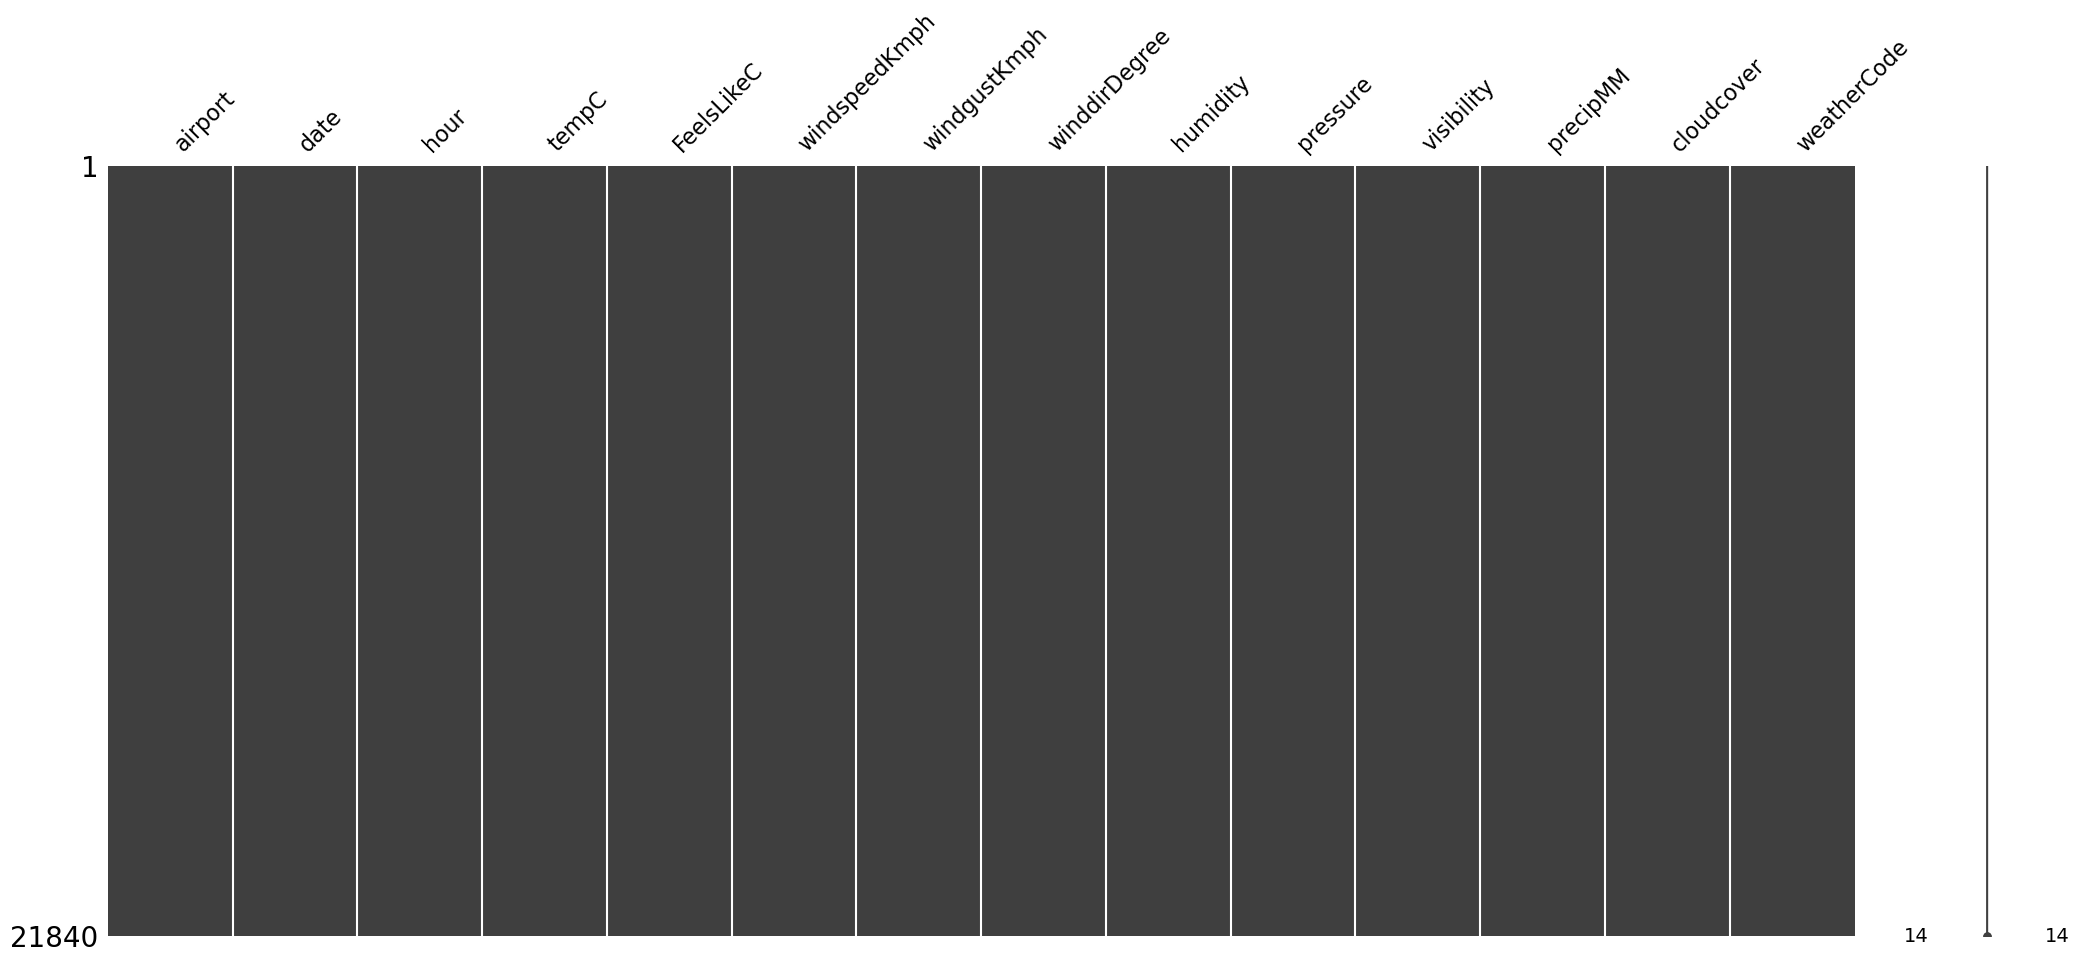

In [11]:
# Visualize the distribution of missing values across the dataset
print(msno.matrix(weather_data))

# Display the count of missing values for each column
print(weather_data.isnull().sum())

A missing value analysis was performed using both programmatic checks and visualization. The missingness matrix confirms that the processed weather dataset contains no missing values across all variables

In [12]:
weather_data.head()

,airport,date,hour,tempC,FeelsLikeC,windspeedKmph,windgustKmph,winddirDegree,humidity,pressure,visibility,precipMM,cloudcover,weatherCode
0,ATL,2016-01-01,0,10,8,11,17,318,91,1023,10,0.1,100,176
1,ATL,2016-01-01,1,8,6,13,22,317,92,1023,10,0.0,100,176
2,ATL,2016-01-01,2,6,3,14,26,315,92,1023,10,0.0,100,122
3,ATL,2016-01-01,3,4,1,16,30,314,93,1023,10,0.0,100,122
4,ATL,2016-01-01,4,4,1,17,30,314,93,1023,10,0.0,100,122


In [13]:
weather_data.tail()

,airport,date,hour,tempC,FeelsLikeC,windspeedKmph,windgustKmph,winddirDegree,humidity,pressure,visibility,precipMM,cloudcover,weatherCode
21835,SFO,2016-03-31,19,13,12,19,20,277,87,1020,10,0.0,99,122
21836,SFO,2016-03-31,20,12,11,17,19,276,89,1020,10,0.0,99,122
21837,SFO,2016-03-31,21,11,9,16,18,276,91,1020,10,0.0,99,122
21838,SFO,2016-03-31,22,11,9,15,18,275,92,1020,10,0.0,100,122
21839,SFO,2016-03-31,23,10,9,15,17,274,92,1020,10,0.0,100,122


In [14]:
weather_data.to_csv("Data/weather_data.csv", index=False)

### Summary

Began with exploring a representative JSON file to understand its nested daily and hourly structure. The data was then flattened to an hourly level, producing one record per airport, date, and hour. Relevant weather attributes such as temperature, wind, visibility, precipitation, and atmospheric conditions were selected and converted to numeric formats. Weather data from all airports and months were combined into a single dataset, and data integrity was validated through duplicate checks and missing value visualizations. The final cleaned and consolidated dataset was saved as `weather_data.csv` for downstream integration with flight data.